In [226]:
import pandas as pd
import numpy as np
df = pd.read_csv('./dataset/TCurieData.csv', na_values=0)
df = df.rename(columns={'Composition': 'formula'})

In [227]:
df.head()

,formula,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
0,Fe69.5Co0.5Mn10Mo5B15,NaN,NaN,20.0,370.00000
1,Fe80Ni6Zr7Nb2B4Cu1,NaN,NaN,20.0,374.00000
2,Fe90Zr7B3,3600.0,873.25952,20.0,388.64693
3,Fe69.5Co0.5Mn10Mo5B15,1800.0,723.00000,20.0,389.00000
4,Fe90Zr7B3,3600.0,822.85321,20.0,389.68647


In [228]:
df.describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
count,98.000000,98.000000,220.000000,220.000000
mean,1668.527573,735.758597,21.677273,599.232518
std,1439.796336,74.034270,3.351607,73.767177
min,60.000000,573.000000,17.500000,370.000000
25%,240.000000,679.500000,20.000000,587.000000
50%,1800.000000,745.514655,20.000000,605.983795
75%,3600.000000,780.500000,22.500000,626.768258
max,3857.047930,924.632090,30.000000,769.000000


In [229]:
from utils import add_feature

df = add_feature.add_composition(df)
df = add_feature.add_element_fraction(df)
#df = add_feature.add_Wen_alloys(df)
#df = add_feature.add_Yang_alloys(df)
#df = add_feature.add_valence_orbitals(df)
#df = add_feature.add_magpie(df)

StrToComposition:   0%|          | 0/220 [00:00<?, ?it/s]

ElementFraction:   0%|          | 0/220 [00:00<?, ?it/s]

In [230]:
np.sum(df.iloc[0][6:].values)

1.0

In [244]:
#index 0 is always row index


In [335]:
from sklearn.model_selection import train_test_split
from botorch.utils.transforms import normalize
import torch

drop_NaN = False
if drop_NaN:
        
    X = df.dropna().drop(['Tc (K)', 
                 'composition',
                 'formula'], axis =1)
    
    y = df.dropna()['Tc (K)']
    

else:
    X = df.drop(['Tc (K)', 
                 'composition',
                 'formula',
                 'Annealing Time (s)',
                 'Annealing Temperature (K)'
                ], axis =1)
    y = df['Tc (K)']

scale_col = [i for i, col in enumerate(X.columns) if col in ['Annealing Time (s)',
                                                             'Annealing Temperature (K)',
                                                             'Thickness (mu m)']]

X = torch.tensor(X.values, dtype=torch.double)
y = torch.tensor(y.values, dtype=torch.double)


In [336]:

print(torch.tensor([x.min() for x in X[:,scale_col].T], dtype=torch.float))
print(torch.tensor([x.max() for x in X[:,scale_col].T], dtype=torch.float))

#bounds = torch.stack([torch.zeros(X.shape[1]), torch.ones(X.shape[1])])
bounds = torch.zeros(2, X.shape[1])
bounds[0,scale_col] = torch.tensor([x.min() for x in X[:,scale_col].T], dtype=torch.float)
bounds[1,scale_col] = torch.tensor([x.max() for x in X[:,scale_col].T], dtype=torch.float)

X = normalize(X, bounds)
y = y
#X = MinMaxScaler(X.values)
#y = MinMaxScaler(y.values)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y.unsqueeze(dim=1), 
                                                    test_size=0.2, 
                                                    random_state=1)

tensor([17.5000])
tensor([30.])


In [339]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
#from botorch.fit import fit_gpytorch_mll
from torch.optim import SGD, Adam

def trainGP(model, mll, optimizer, num_epochs):
    #num_epochs = 3000
    for epoch in range(num_epochs):
        # clear gradients
        optimizer.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output = model(X_train)
        # Compute negative marginal log likelihood
        try:
            loss = - mll(output, model.train_targets)
        except:
            print("[{}] Couldn't train".format(epoch),flush=True)
            break
        # back prop gradients
        loss.backward()
        # print every X iterations
        if True and ((epoch + 1) % 500 == 0):
            print(
                f"Epoch {epoch+1:>3}/{num_epochs} - Loss: {loss.item():>4.3f} "
                # f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
                f"noise: {model.likelihood.noise.item():>4.3f}"
            )
        optimizer.step()

outcome_transform = Standardize(m=1)
model = SingleTaskGP(X_train, 
                     y_train, 
                     outcome_transform=outcome_transform,
                     covar_module=ScaleKernel(RBFKernel()),
)



optimizer_kwargs = {'lr': 1e-3, 'weight_decay': 1e-3}
model.train()
trainGP(model, 
        mll = ExactMarginalLogLikelihood(model.likelihood, model), 
        optimizer = Adam([{'params': model.parameters()}], **optimizer_kwargs),
        num_epochs=3000
       )

Epoch 500/3000 - Loss: 1.429 noise: 1.475
Epoch 1000/3000 - Loss: 1.206 noise: 0.820
Epoch 1500/3000 - Loss: 0.806 noise: 0.118
Epoch 2000/3000 - Loss: 0.788 noise: 0.108
Epoch 2500/3000 - Loss: 0.788 noise: 0.108
Epoch 3000/3000 - Loss: 0.788 noise: 0.108


In [340]:
import gpytorch
from sklearn.metrics import mean_squared_error, r2_score

def evaluateGP(model, X):
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # compute posterior
        posterior = model.posterior(X)
    return posterior.mean.squeeze().numpy(), posterior.stddev.numpy()
    

y_train_predicted, y_train_stddev = evaluateGP(model, X_train)
y_test_predicted, y_test_stddev = evaluateGP(model, X_test)

for y_true, y_pred, l in zip([y_train.cpu().squeeze().numpy(), y_test.cpu().squeeze().numpy()],
                             [y_train_predicted, y_test_predicted],
                             ['train', 'test']):

    print(f"{l} R2 = {r2_score(y_true= y_true, y_pred = y_pred): .03f}")
    print(f'{l} RMSE = {np.sqrt(mean_squared_error(y_true,y_pred)):.3f}')

train R2 =  0.922
train RMSE = 20.008
test R2 =  0.855
test RMSE = 30.236


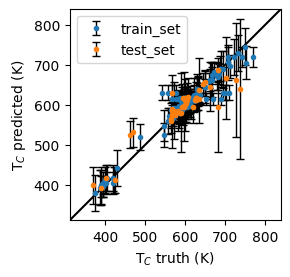

In [341]:
#from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=[3,3])
#y_truth = y_train.cpu().squeeze().numpy()
#y_model = y_train_predicted

# y_truth = y_test.cpu().squeeze().numpy()
# y_model = y_test_predicted

#y_predicted = posterior.mean.cpu().squeeze().numpy()
for y_truth, y_model, stddev, l in zip([y_train.cpu().squeeze().numpy(), y_test.cpu().squeeze().numpy()],
                                  [y_train_predicted, y_test_predicted],
                                  [y_train_stddev, y_test_stddev],
                                  ['train_set', 'test_set']
                                 ):
    yerr = 2*np.array([stddev,stddev])
    ax.errorbar(y_truth, y_model, yerr=yerr, label=l,
                fmt='.',capsize=3, elinewidth=1, ecolor = "black")
ymin = np.min([ax.get_xlim()[0], ax.get_ylim()[0]])
ymax = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_xlim([ymin, ymax])
ax.set_ylim([ymin, ymax])
ax.axline((0, 0), slope=1, color='k')
ax.legend()
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.set_xlabel(r'T$_{C}$ truth (K)')
ax.set_ylabel(r'T$_{C}$ predicted (K)')
ax.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig('gp.png', dpi=300)